In [1]:
import os
import cv2
import csv
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torchsummary import summary

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.utils.data import Subset, SubsetRandomSampler, ConcatDataset

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [35]:
# category = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'sad':4, 'surprise':5, 'neutral':6}

# train_images = []
# train_labels = []
# table = []
# img_name = []
# labels = []

# for class_name, class_label in category.items():
#     path = os.path.join("train/train", class_name)
#     for img_file in os.listdir(path):
#         img_path = os.path.join(path, img_file)
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         train_images.append(img)
#         train_labels.append(class_label)
        
#         table.append([class_name+'/'+img_file, class_label])

# with open('labels.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(table)

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        idx = idx%28708
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
train_dataset = CustomImageDataset(annotations_file='labels.csv', img_dir='train/train')

In [5]:
image_flip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
])
image_rotation = transforms.Compose([
    transforms.RandomRotation(15),
])
image_crop = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomCrop((48,48)),
])
image_crop_rotation = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomCrop((48,48)),
    transforms.RandomRotation(15),
])

In [6]:
train_dataset1 = CustomImageDataset(annotations_file='labels.csv', img_dir='train/train')
train_dataset2 = CustomImageDataset(annotations_file='labels.csv', img_dir='train/train', transform=image_flip)
train_dataset3 = CustomImageDataset(annotations_file='labels.csv', img_dir='train/train', transform=image_rotation)
train_dataset4 = CustomImageDataset(annotations_file='labels.csv', img_dir='train/train', transform=image_crop)
train_dataset5 = CustomImageDataset(annotations_file='labels.csv', img_dir='train/train', transform=image_crop_rotation)

In [7]:
train_dataset = ConcatDataset([train_dataset1, train_dataset2, train_dataset3, train_dataset4, train_dataset5])

In [8]:
def get_train_valid_dataloaders(train_set, valid_set, split_ratio, batch_size, shuffle=True, num_workers=2):
    idx = list(range(len(train_set)))
    
    if shuffle:
        np.random.shuffle(idx)
        
    split = int(np.floor(split_ratio * len(train_set)))
    
    train_idx, valid_idx = idx[split:], idx[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler) #, num_workers=num_workers
    valid_loader = DataLoader(valid_set, batch_size=batch_size, sampler=valid_sampler) #, num_workers=num_workers
    
    return train_loader, valid_loader

In [9]:
# hyperparameters
batch_size = 128
in_channels = 1
n_classes = 7
n_epochs = 80
lr = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:',device)

device: cuda


In [10]:
train_loader, valid_loader = get_train_valid_dataloaders(train_dataset, train_dataset, 0.2, batch_size=batch_size)

In [11]:
num_images1 = len(train_loader) * train_loader.batch_size
num_images2 = len(valid_loader) * train_loader.batch_size
print(num_images1+num_images2)

172416


In [12]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)

torch.Size([128, 1, 48, 48])


In [16]:
class test1(nn.Module):
    def __init__(self, in_channels, n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        
#         self.dropout = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=96, padding='same', kernel_size=3)
        self.bn1 = nn.BatchNorm2d(96)
        self.max_pool = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=0.4)
        
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=128, padding='same', kernel_size=5)
        self.bn2 = nn.BatchNorm2d(128)
        self.drop2 = nn.Dropout(p=0.1)
        
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=384, padding='same', kernel_size=3)
        self.bn3 = nn.BatchNorm2d(384)
        self.drop3 = nn.Dropout(p=0.2)
        
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=448, padding='same', kernel_size=3)
        self.bn4 = nn.BatchNorm2d(448)
        self.drop4 = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(in_features=448*9, out_features=128)
        self.bn5 = nn.BatchNorm1d(128)
        self.drop5 = nn.Dropout(p=0.1)
        
        self.fc2 = nn.Linear(in_features=128, out_features=96)
        self.bn6 = nn.BatchNorm1d(96)
        self.drop6 = nn.Dropout(p=0)
        
        self.fc3 = nn.Linear(in_features=96, out_features=self.n_classes)
                
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.max_pool(x)
        x = self.drop1(x)
        
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.max_pool(x)
        x = self.drop2(x)
        
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.max_pool(x)
        x = self.drop3(x)
        
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.max_pool(x)
        x = self.drop4(x)

        x = x.view(x.shape[0], -1)
        x = torch.relu(self.bn5(self.fc1(x)))
        x = self.drop5(x)
        x = torch.relu(self.bn6(self.fc2(x)))
        x = self.drop6(x)
        logit = self.fc3(x)
        return logit

In [18]:
model = test1(in_channels, n_classes).to(device)
print(model)

test1(
  (conv1): Conv2d(1, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.4, inplace=False)
  (conv2): Conv2d(96, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.1, inplace=False)
  (conv3): Conv2d(128, 384, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.2, inplace=False)
  (conv4): Conv2d(384, 448, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn4): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop4): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=4032, out_features=128, bias=True)
  (bn5): Batch

In [20]:
# summary(model, input_size=(1, 48, 48))

In [21]:
def train(model, train_loader, device, optimizer, loss_fn):
    model.train()
    train_loss = 0.
    n_corrects = 0
    total = 0
    for idx,(images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images.float())
        _, predictions = torch.max(outputs, dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        current_lr = optimizer.param_groups[0]['lr']

        if (idx+1) % 200 == 0:
            print(idx+1, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d) | lr: %.5f'
                  % (train_loss/(idx+1), 100.*n_corrects/total, n_corrects, total, current_lr))
    train_loss = train_loss/len(train_loader.sampler)

    return train_loss, n_corrects/total

In [22]:
@torch.no_grad()
def validate(model, valid_loader, device, loss_fn):
    model.eval()
    n_corrects = 0
    total = 0
    valid_loss = 0.
    for idx, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device
                           
        outputs = model(images.float())
        loss = loss_fn(outputs, labels)
        _, predictions = torch.max(outputs, dim=1)
        n_corrects += predictions.eq(labels).sum().item()
        total += labels.size(0)
        valid_loss += loss.item()*images.size(0)

    valid_accuracy = n_corrects / total
    print(f"The number of valid images is {total} and the accuracy is {100 * n_corrects/total}")
    
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    return valid_loss, valid_accuracy

In [23]:
model_name = model.__class__.__name__
model_name

'test1'

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.00207532)
loss_fn = nn.CrossEntropyLoss()

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, min_lr=0.0001)
is_valid_available = True

In [26]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'---Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [27]:
best_loss = float('inf')
early_stopping = EarlyStopping(patience=5, verbose=True)

train_loss_list = []
valid_loss_list = []
for epoch in range(1, n_epochs+1):
    training_loss, training_accuracy = train(model, train_loader, device, optimizer, loss_fn)
    valid_loss, valid_accuracy = validate(model, valid_loader, device, loss_fn)
    
    train_loss_list.append(training_loss)
    valid_loss_list.append(valid_loss)

    if scheduler is not None and is_valid_available:
        scheduler.step(valid_loss)
    elif scheduler is not None:
        scheduler.step()

    print(f"Epoch {epoch}/{n_epochs}: training accuracy: {training_accuracy}, valid accuracy: {valid_accuracy}")
    
    early_stopping(valid_loss, model)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
print("------best loss:", best_loss)

200 1077 Loss: 214.080 | Acc: 32.906% (8424/25600) | lr: 0.00208
400 1077 Loss: 199.218 | Acc: 38.312% (19616/51200) | lr: 0.00208
600 1077 Loss: 190.073 | Acc: 41.540% (31903/76800) | lr: 0.00208
800 1077 Loss: 183.469 | Acc: 43.833% (44885/102400) | lr: 0.00208
1000 1077 Loss: 178.253 | Acc: 45.698% (58494/128000) | lr: 0.00208
The number of valid images is 34449 and the accuracy is 54.14090394496212
Epoch 1/80: training accuracy: 0.4628335474132613, valid accuracy: 0.5414090394496212
---Validation loss decreased (inf --> 1.203339).  Saving model ...
200 1077 Loss: 151.929 | Acc: 54.844% (14040/25600) | lr: 0.00208
400 1077 Loss: 150.233 | Acc: 55.307% (28317/51200) | lr: 0.00208
600 1077 Loss: 149.483 | Acc: 55.530% (42647/76800) | lr: 0.00208
800 1077 Loss: 147.735 | Acc: 56.053% (57398/102400) | lr: 0.00208
1000 1077 Loss: 146.315 | Acc: 56.491% (72309/128000) | lr: 0.00208
The number of valid images is 34449 and the accuracy is 58.37324740921362
Epoch 2/80: training accuracy: 0.5

200 1077 Loss: 76.007 | Acc: 78.258% (20034/25600) | lr: 0.00208
400 1077 Loss: 77.110 | Acc: 77.934% (39902/51200) | lr: 0.00208
600 1077 Loss: 77.173 | Acc: 77.814% (59761/76800) | lr: 0.00208
800 1077 Loss: 77.403 | Acc: 77.721% (79586/102400) | lr: 0.00208
1000 1077 Loss: 77.228 | Acc: 77.803% (99588/128000) | lr: 0.00208
The number of valid images is 34449 and the accuracy is 76.33893581816598
Epoch 16/80: training accuracy: 0.7778285764047634, valid accuracy: 0.7633893581816599
EarlyStopping counter: 1 out of 5
200 1077 Loss: 74.094 | Acc: 78.594% (20120/25600) | lr: 0.00208
400 1077 Loss: 74.867 | Acc: 78.457% (40170/51200) | lr: 0.00208
600 1077 Loss: 75.236 | Acc: 78.417% (60224/76800) | lr: 0.00208
800 1077 Loss: 75.266 | Acc: 78.507% (80391/102400) | lr: 0.00208
1000 1077 Loss: 75.374 | Acc: 78.482% (100457/128000) | lr: 0.00208
The number of valid images is 34449 and the accuracy is 77.37525037011234
Epoch 17/80: training accuracy: 0.7845630229537225, valid accuracy: 0.7737

600 1077 Loss: 59.415 | Acc: 83.154% (63862/76800) | lr: 0.00208
800 1077 Loss: 59.699 | Acc: 83.066% (85060/102400) | lr: 0.00208
1000 1077 Loss: 60.053 | Acc: 82.899% (106111/128000) | lr: 0.00208
The number of valid images is 34449 and the accuracy is 81.64533077883247
Epoch 31/80: training accuracy: 0.8290553632464677, valid accuracy: 0.8164533077883248
EarlyStopping counter: 2 out of 5
200 1077 Loss: 59.089 | Acc: 83.121% (21279/25600) | lr: 0.00208
400 1077 Loss: 58.572 | Acc: 83.236% (42617/51200) | lr: 0.00208
600 1077 Loss: 59.224 | Acc: 83.122% (63838/76800) | lr: 0.00208
800 1077 Loss: 59.316 | Acc: 83.124% (85119/102400) | lr: 0.00208
1000 1077 Loss: 59.362 | Acc: 83.134% (106412/128000) | lr: 0.00208
The number of valid images is 34449 and the accuracy is 81.59598246683503
Epoch 32/80: training accuracy: 0.831239704206852, valid accuracy: 0.8159598246683503
EarlyStopping counter: 3 out of 5
200 1077 Loss: 54.494 | Acc: 84.730% (21691/25600) | lr: 0.00021
400 1077 Loss: 54.

800 1077 Loss: 45.625 | Acc: 87.076% (89166/102400) | lr: 0.00021
1000 1077 Loss: 45.421 | Acc: 87.095% (111482/128000) | lr: 0.00021
The number of valid images is 34449 and the accuracy is 84.62074370809022
Epoch 46/80: training accuracy: 0.8711529111241736, valid accuracy: 0.8462074370809022
---Validation loss decreased (0.467667 --> 0.467387).  Saving model ...
200 1077 Loss: 45.616 | Acc: 87.230% (22331/25600) | lr: 0.00021
400 1077 Loss: 45.969 | Acc: 87.115% (44603/51200) | lr: 0.00021
600 1077 Loss: 45.858 | Acc: 87.161% (66940/76800) | lr: 0.00021
800 1077 Loss: 45.996 | Acc: 87.094% (89184/102400) | lr: 0.00021
1000 1077 Loss: 45.750 | Acc: 87.132% (111529/128000) | lr: 0.00021
The number of valid images is 34449 and the accuracy is 84.55688118668176
Epoch 47/80: training accuracy: 0.871769751594714, valid accuracy: 0.8455688118668176
EarlyStopping counter: 1 out of 5
200 1077 Loss: 45.181 | Acc: 87.410% (22377/25600) | lr: 0.00021
400 1077 Loss: 45.360 | Acc: 87.262% (44678/5

The number of valid images is 34449 and the accuracy is 85.28259165723243
Epoch 61/80: training accuracy: 0.880042670846668, valid accuracy: 0.8528259165723243
EarlyStopping counter: 4 out of 5
200 1077 Loss: 42.098 | Acc: 88.242% (22590/25600) | lr: 0.00010
400 1077 Loss: 42.626 | Acc: 88.064% (45089/51200) | lr: 0.00010
600 1077 Loss: 42.680 | Acc: 88.033% (67609/76800) | lr: 0.00010
800 1077 Loss: 42.617 | Acc: 88.005% (90117/102400) | lr: 0.00010
1000 1077 Loss: 42.506 | Acc: 88.045% (112698/128000) | lr: 0.00010
The number of valid images is 34449 and the accuracy is 84.98940462712996
Epoch 62/80: training accuracy: 0.8805506571165248, valid accuracy: 0.8498940462712996
EarlyStopping counter: 5 out of 5
Early stopping
------best loss: 0.4530216773406401


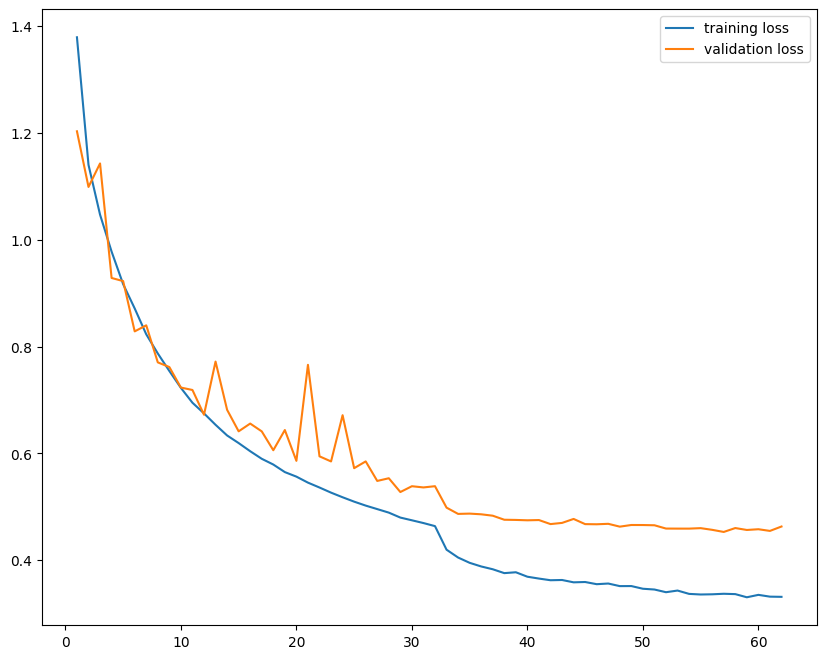

In [28]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(range(1, len(train_loss_list)+1), train_loss_list, label="training loss")
ax.plot(range(1, len(valid_loss_list)+1), valid_loss_list, label="validation loss")
ax.legend()
plt.show()

In [29]:
class TestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.image_name = []
        for image_file in os.listdir(data_dir):
            self.image_name.append(int(image_file[:-4]))
            self.images.append(os.path.join(data_dir, image_file))
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = read_image(self.images[index])
        image_name = self.image_name[index]
        if self.transform is not None:
            image = self.transform(image)
        return image_name, image

In [30]:
test_data = TestDataset(data_dir = 'testing data/testing data')
test_loader = DataLoader(test_data, batch_size=batch_size)

In [31]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

ID = []
Category = []

with torch.no_grad():
    for image_name, images in test_loader:
        images = images.to(device)
        outputs = model(images.float())
        _, predicted = torch.max(outputs.data, 1)
        for j in range(len(predicted)):
            ID.append(image_name[j].item())
            Category.append(predicted[j].item())

In [32]:
import time

now = time.strftime("%Y%m%d-%H%M%S")
df = pd.DataFrame({'ID':ID, 'Category':Category})
df1 = df.sort_values(by=['ID'])
best_loss = round(best_loss, 4)

if best_loss <= 1.04:
    df1.to_csv(f'{model_name}_{now}_{best_loss}.csv', index=False)